In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [62]:
# 12hrs light, 12hrs dark
def LD(t, intensity, off_time=12, daylength=24):
    time = t % daylength
    is_light = time < off_time
    
    return is_light * intensity

# LD function with a pulse of light or dark at the specified time and day, for the specified length (in hours)
def LD_pulse(t, intensity, pulse_day, pulse_time, pulse_length=2, off_time=12, daylength=24):
    time = t % daylength
    day = t // daylength
    base = LD(t, intensity, off_time, daylength)

    is_during_pulse = (day == pulse_day) & (pulse_time < time) & (time < pulse_time + pulse_length)

    # if not in pulse, return the base signal; if in pulse return the inverted one
    # done a little weirdly so that the function works when vectorized
    return is_during_pulse * (intensity - base) + (1 - is_during_pulse) * base
        

In [135]:
# differential equations for x, y
def cartesian_lights(t, p, l, A, tau, ifunc):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    light_intensity = ifunc(t)
    dx = l * x * (A - r) - 2 * np.pi * y / tau - light_intensity
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    return [dx, dy]

def get_simulation_result(l, tau, hours, intensity, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    ifunc = lambda t: LD(t, intensity)
    p0 = [A, 0]
    
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)
    return t, result.y

def get_pulse_simulation_result(l, tau, hours, intensity, pulse_day, pulse_time, pulse_length=2, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    
    ifunc = lambda t: LD_pulse(t, intensity, pulse_day, pulse_time, pulse_length)
    p0 = [A, 0]
    
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)
    return t, result.y

In [190]:
rows = []

pulse_starts = [2, 4, 6, 8, 14, 16, 18, 20]
periods = range(20, 29)

l = .1
sim_hours = 20 * 24
pulse_day = 15
intensity = .15

for pulse_time in pulse_starts:
    for period in periods:
        t, (ctrl_result, _) = get_simulation_result(l, period, sim_hours, intensity)
        _, (pulse_result, _) = get_pulse_simulation_result(l, period, sim_hours, intensity, pulse_day, pulse_time)

        pulse_time_absolute = (24 * pulse_day) + pulse_time

        measurement_interval = 2
        
        is_pulse = (pulse_time_absolute <= t) & (t < pulse_time_absolute + 1)
        ctrl_avg = ctrl_result[is_pulse].mean()
        pulse_avg = pulse_result[is_pulse].mean()

        rows.append({
            'zt': pulse_time,
            'tau': period,
            'ctrl_avg': ctrl_avg,
            'pulse_avg': pulse_avg
        })

df = pd.DataFrame(rows)

display(df)

,zt,tau,ctrl_avg,pulse_avg
0,2,20,-0.750843,-0.710007
1,2,21,-1.183711,-1.120103
2,2,22,-1.388817,-1.323485
3,2,23,-1.137299,-1.101365
4,2,24,-0.915226,-0.866704
...,...,...,...,...
67,20,24,1.003868,0.941501
68,20,25,1.173057,1.085824
69,20,26,1.183595,1.092808
70,20,27,1.087418,0.962063


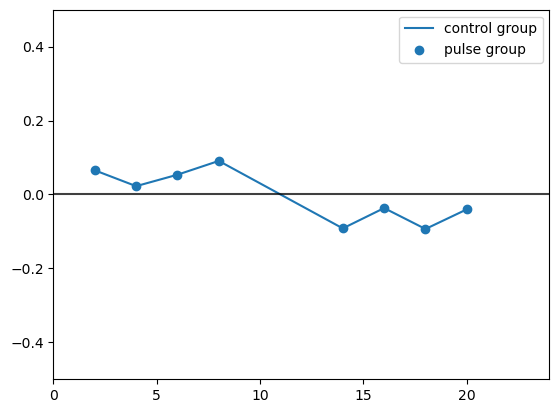

In [191]:
tau23 = df[df.tau == 22]

plt.xlim(0, 24)
plt.ylim(-.5, .5)
plt.plot(tau23.zt, tau23.pulse_avg - tau23.ctrl_avg)
plt.scatter(tau23.zt, tau23.pulse_avg - tau23.ctrl_avg)

plt.hlines(0, 0, 24, color='black', alpha=.75)

plt.legend(['control group', 'pulse group'])

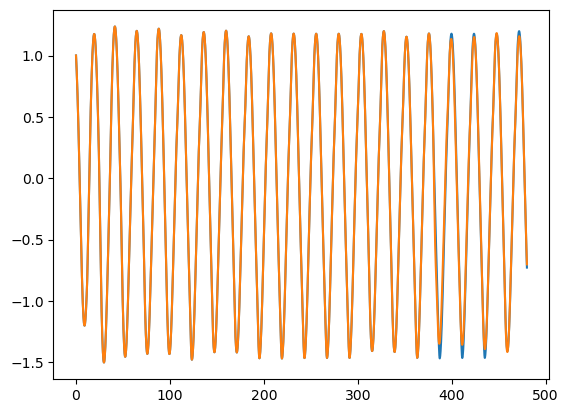

In [188]:
l = .1
sim_hours = 20 * 24
pulse_day = 15
intensity = .15

pulse_start = 2
period = 22

t, (ctrl_result, _) = get_simulation_result(l, period, sim_hours, intensity)
_, (pulse_result, _) = get_pulse_simulation_result(l, period, sim_hours, intensity, pulse_day, pulse_time)

plt.plot(t, ctrl_result)
plt.plot(t, pulse_result)
plt.plot(